In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [2]:
data = pd.read_csv("/kaggle/input/health/diabetes_data.csv")

print(data.head())

print(data.info())

print(data.isnull().sum())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  

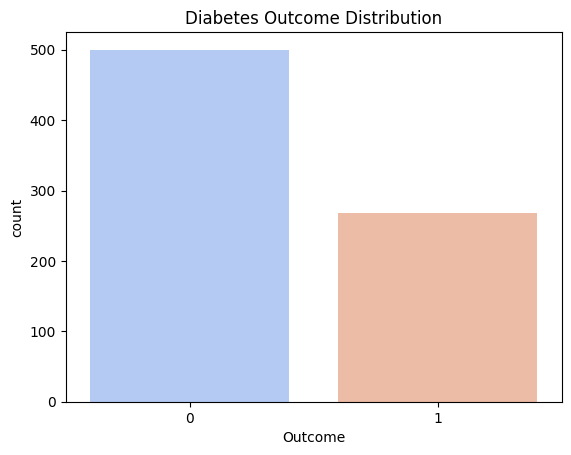

In [3]:
print(data.describe())

sns.countplot(x=data['Outcome'], palette='coolwarm')
plt.title("Diabetes Outcome Distribution")
plt.show()

In [4]:
X = data.drop(columns=["Outcome"])
y = data["Outcome"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (614, 8)
Testing Data Shape: (154, 8)


In [19]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  
    'subsample': [0.6, 0.8, 1.0], 
    'colsample_bytree': [0.6, 0.8, 1.0], 
    'n_estimators': [100, 200, 300] 
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,  
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

best_xgb = xgb.XGBClassifier(**grid_search.best_params_, use_label_encoder=False, eval_metric="logloss")
best_xgb.fit(X_train, y_train)

y_pred_train = best_xgb.predict(X_train)
y_pred_test = best_xgb.predict(X_test)

print("XGBoost Training Accuracy:", accuracy_score(y_train, y_pred_train))
print("XGBoost Testing  Accuracy:", accuracy_score(y_test, y_pred_test))
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_test))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'n_estimators': 200, 'subsample': 0.6}
XGBoost Training Accuracy: 0.9039087947882736
XGBoost Testing  Accuracy: 0.7597402597402597
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.81      0.81        99
           1       0.66      0.67      0.67        55

    accuracy                           0.76       154
   macro avg       0.74      0.74      0.74       154
weighted avg       0.76      0.76      0.76       154



In [20]:
param_grid2 = {
    'max_depth': [3, 5, 7],  
    'min_child_weight': [1, 3, 5],  
    'gamma': [0, 0.1, 0.3, 0.5], 
}

grid_search2 = GridSearchCV(
    estimator=xgb.XGBClassifier(
        colsample_bytree=1.0,
        learning_rate=0.01,
        n_estimators=200,
        subsample=0.6,
        use_label_encoder=False,
        eval_metric="logloss"
    ),
    param_grid=param_grid2,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search2.fit(X_train, y_train)

print("Best Parameters after second tuning:", grid_search2.best_params_)

best_xgb2 = xgb.XGBClassifier(**grid_search2.best_params_, 
                              colsample_bytree=1.0, 
                              learning_rate=0.01, 
                              n_estimators=200, 
                              subsample=0.6, 
                              use_label_encoder=False, 
                              eval_metric="logloss")

best_xgb2.fit(X_train, y_train)

y_pred_train2 = best_xgb2.predict(X_train)
y_pred_test2 = best_xgb2.predict(X_test)

print("XGBoost Training Accuracy (After Second Tuning):", accuracy_score(y_train, y_pred_train2))
print("XGBoost Testing Accuracy (After Second Tuning):", accuracy_score(y_test, y_pred_test2))
print("XGBoost Classification Report (After Second Tuning):\n", classification_report(y_test, y_pred_test2))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters after second tuning: {'gamma': 0.1, 'max_depth': 7, 'min_child_weight': 3}
XGBoost Training Accuracy (After Second Tuning): 0.8615635179153095
XGBoost Testing Accuracy (After Second Tuning): 0.7662337662337663
XGBoost Classification Report (After Second Tuning):
               precision    recall  f1-score   support

           0       0.82      0.82      0.82        99
           1       0.67      0.67      0.67        55

    accuracy                           0.77       154
   macro avg       0.75      0.75      0.75       154
weighted avg       0.77      0.77      0.77       154



In [24]:
import pickle
import joblib
import xgboost as xgb

with open("xgboost_diabetes_model.pkl", "wb") as file:
    pickle.dump(best_xgb2, file)

joblib.dump(best_xgb2, "xgboost_diabetes_model.joblib")

print("✅ Model saved successfully!")

✅ Model saved successfully!


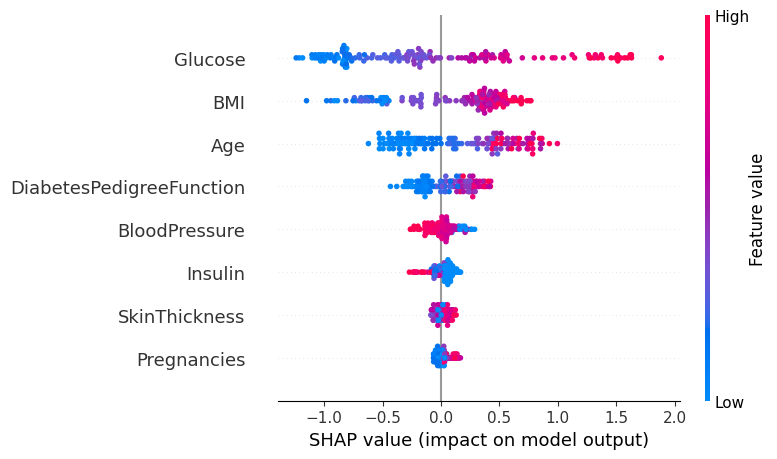

In [26]:
import shap
import matplotlib.pyplot as plt

explainer = shap.Explainer(best_xgb2, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

In [27]:
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[0].values, X_test.iloc[0])

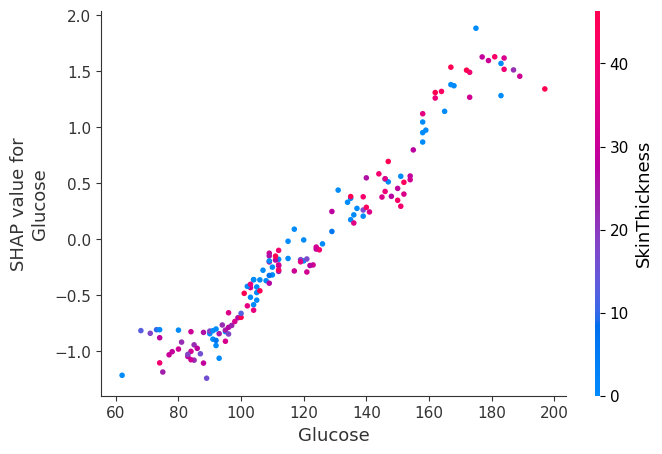

In [28]:
shap.dependence_plot("Glucose", shap_values.values, X_test)